## Active Balancing Mechanism
Quick implementation of balancing method proposed in article  
https://dl.acm.org/doi/fullHtml/10.1145/3357253#algorithm1  
Testing on one artificial dataset and one real with XGBoost.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from sklearn.naive_bayes import GaussianNB
from scipy.stats import entropy

### Creating artificial dataset

In [4]:
class_1 = np.random.uniform(0, 10, 50)
class_1_y = np.random.uniform(1, 2, 50)
class_0 = np.random.uniform(0, 10, 1000)
class_0_y = np.random.uniform(0, 1.2, 1000)

In [5]:
class_1 = np.column_stack((class_1, class_1_y, np.ones(50)))
class_0 = np.column_stack((class_0, class_0_y, np.zeros(1000)))
df = np.concatenate((class_0, class_1), axis=0)

In [6]:
df = pd.DataFrame({'p1': df[:,0], 'p2': df[:,1], 'y': df[:,2]})

In [7]:
df.head(5)

,p1,p2,y
0,7.641385,0.228858,0.0
1,0.001858,0.249233,0.0
2,3.702823,0.060637,0.0
3,8.711934,0.996320,0.0
4,2.162850,0.051728,0.0


First implementation step-by-step

In [11]:
df_maj = df[df['y']==0]
df_min = df[df['y']==1]
df_maj.reset_index(inplace=True, drop=True)
df_min.reset_index(inplace=True, drop=True)

In [12]:
random_rows = random.sample(range(0, len(df_maj)), 2)
df_training = df_maj.loc[random_rows]
df_training.reset_index(inplace=True, drop=True)
df_train = df_min.append(df_training, ignore_index=True)
df_train.reset_index(inplace = True, drop=True)
df_test = df_maj.drop(random_rows, axis=0) 

In [14]:
k = (len(df_min) - len(df_training))/2

In [15]:
#Initial step
gnb = GaussianNB()
#Train separate target
df_train_X = df_train.drop('y', axis=1)
df_train_y = df_train['y']
gnb.fit(df_train_X, df_train_y)
#Test separate target
df_test_X = df_test.drop('y', axis=1)
df_test_y = df_test['y']
predict_proba = gnb.predict_proba(df_test_X)

In [16]:
entr = np.apply_along_axis(entropy, 1, predict_proba)

In [17]:
for i in range(int(k)):
    #Selecting 2 samples with highest entropy
    k_high_entr = np.argsort(entr)[-2:]
    k_X = df_test_X.loc[k_high_entr]
    k_X.reset_index(inplace=True, drop=True)
    k_y = df_test_y.loc[k_high_entr]
    k_y.reset_index(inplace=True, drop=True)
    #Update D_train
    df_train_X = df_train_X.append(k_X, ignore_index=True)
    df_train_X.reset_index(inplace=True, drop=True)
    df_train_y = df_train_y.append(k_y, ignore_index=True)
    df_train_y.reset_index(inplace=True, drop=True)
    #Drop from D_test
    df_test_X.drop(k_high_entr, axis='rows', inplace=True)
    df_test_y.drop(k_high_entr, axis='rows', inplace=True)
    df_test_X.reset_index(inplace=True, drop=True)
    df_test_y.reset_index(inplace=True, drop=True)
    #Retraining GNB
    gnb = GaussianNB()
    gnb.fit(df_train_X, df_train_y)
    predict_proba = gnb.predict_proba(df_test_X)
    entr = np.apply_along_axis(entropy, 1, predict_proba)

In [18]:
result = pd.concat([df_train_X, df_train_y], axis=1)

In [19]:
result.head()

,p1,p2,y
0,7.821554,1.114157,1.0
1,9.735290,1.988708,1.0
2,1.888350,1.500442,1.0
3,2.448545,1.692316,1.0
4,4.117200,1.130434,1.0


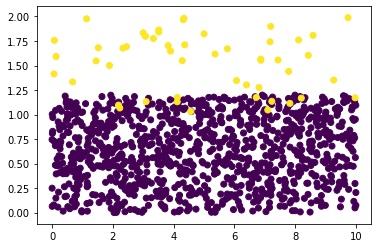

In [8]:
plt.scatter(x=df['p1'], y=df['p2'], c=df['y'])

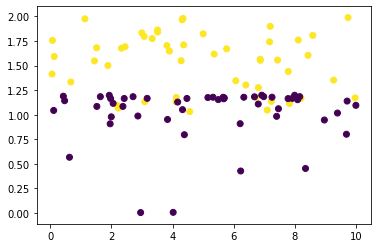

In [20]:
plt.scatter(x=result['p1'], y=result['p2'], c=result['y'])

### Implementation closed to function

In [21]:
#Closing method to function
def active_balancing(df, y):
    """
    df - input dataframe to balance
    y - name of target variable (must be binary)
    """
    
    #Majority-minority divide
    df_maj = df[df[y]==0]
    df_min = df[df[y]==1]
    df_maj.reset_index(inplace=True, drop=True)
    df_min.reset_index(inplace=True, drop=True)
    
    #Training, train, test sets
    random_rows = random.sample(range(0, len(df_maj)), 2)
    df_training = df_maj.loc[random_rows]
    df_training.reset_index(inplace=True, drop=True)
    df_train = df_min.append(df_training, ignore_index=True)
    df_train.reset_index(inplace = True, drop=True)
    df_test = df_maj.drop(random_rows, axis=0) 
    
    #K - number of iterations
    k = (len(df_min) - len(df_training))/2
    
    #Initial step
    gnb = GaussianNB()
    #Train separate target
    df_train_X = df_train.drop('y', axis=1)
    df_train_y = df_train['y']
    gnb.fit(df_train_X, df_train_y)
    #Test separate target
    df_test_X = df_test.drop('y', axis=1)
    df_test_y = df_test['y']
    predict_proba = gnb.predict_proba(df_test_X)
    entr = np.apply_along_axis(entropy, 1, predict_proba)
    
    for i in range(int(k)):
        #Selecting 2 samples with highest entropy
        k_high_entr = np.argsort(entr)[-2:]
        k_X = df_test_X.loc[k_high_entr]
        k_X.reset_index(inplace=True, drop=True)
        k_y = df_test_y.loc[k_high_entr]
        k_y.reset_index(inplace=True, drop=True)
        #Update D_train
        df_train_X = df_train_X.append(k_X, ignore_index=True)
        df_train_X.reset_index(inplace=True, drop=True)
        df_train_y = df_train_y.append(k_y, ignore_index=True)
        df_train_y.reset_index(inplace=True, drop=True)
        #Drop from D_test
        df_test_X.drop(k_high_entr, axis='rows', inplace=True)
        df_test_y.drop(k_high_entr, axis='rows', inplace=True)
        df_test_X.reset_index(inplace=True, drop=True)
        df_test_y.reset_index(inplace=True, drop=True)
        #Retraining GNB
        gnb = GaussianNB()
        gnb.fit(df_train_X, df_train_y)
        predict_proba = gnb.predict_proba(df_test_X)
        entr = np.apply_along_axis(entropy, 1, predict_proba)

    return(pd.concat([df_train_X, df_train_y], axis=1))

In [23]:
balanced_df = active_balancing(df, 'y')

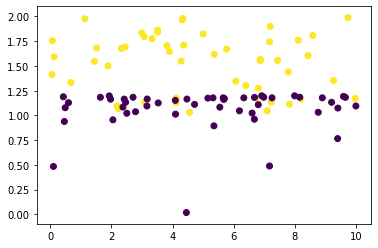

In [25]:
plt.scatter(balanced_df.p1, balanced_df.p2, c=balanced_df.y)

## Test on real dataset

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, plot_confusion_matrix
import xgboost as xgb
from imblearn.metrics import geometric_mean_score

In [47]:
df = pd.read_csv("bank_marketing_weka_dataset.csv")
df['y'] = df['y'].map(dict(yes=1, no=0))

In [48]:
df = pd.get_dummies(df)

In [49]:
df.y.value_counts()

0    4000
1     521
Name: y, dtype: int64

In [50]:
X = df.drop('y', axis=1)
y = df.y

### Train-test split
Test set treated as unseen data - no balancing.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Balancing trainig dataset

In [52]:
X_train_balanced = active_balancing(pd.concat([X_train, y_train], axis=1), 'y')

In [53]:
X_train_balanced.y.value_counts()

1    391
0    390
Name: y, dtype: int64

In [54]:
X_train_b = X_train_balanced.drop('y', axis=1)
y_train_b = X_train_balanced.y

## Score on test dataset
### Model trained on balanced dataset

In [55]:
xgb1 = xgb.XGBClassifier()
xgb1.fit(X_train_b, y_train_b)
predict = xgb1.predict(X_test)
recall_score(y_test, predict)

0.6384615384615384

In [56]:
geometric_mean_score(y_test, predict)

0.6374117243145958

### Without balancing

In [64]:
xgb2 = xgb.XGBClassifier()
xgb2.fit(X_train, y_train)
predict = xgb2.predict(X_test)
recall_score(y_test, predict)

0.3923076923076923

In [65]:
geometric_mean_score(y_test, predict)

0.6149786373139887

Training set: unbalanced

Training set: balanced

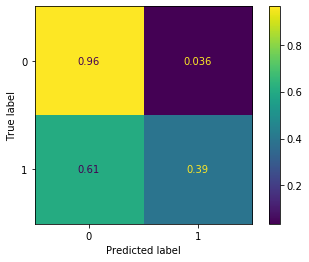

In [67]:
plot_confusion_matrix(X = X_test, y_true = y_test, estimator=xgb2, normalize='true')

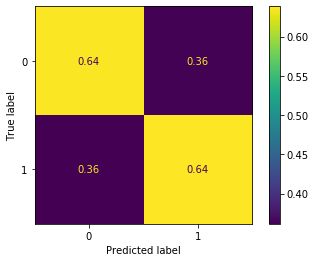

In [63]:
plot_confusion_matrix(X = X_test, y_true = y_test, estimator=xgb1, normalize='true')

Model trained on balanced dataset achieved interesting results. It seems that model learned to pay the same attetion to both classes on test data.